## Recreating the Master Unit List

#### setup/imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import sqlalchemy as sa
import logging
import sys
import copy
from copy import deepcopy

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [4]:
import sys
sys.path.append("../") # go to parent dir
from plant_part_agg_eia import *
from plant_parts import plant_parts

In [5]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

#### defining a table grabbing object

In [6]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])
pt = pudl.output.pudltabl.get_table_meta(pudl_engine)
start_date=None
end_date=None
freq='AS'

In [7]:
from plant_parts import plant_parts

In [8]:
self = CompileTables(pudl_engine, freq='AS', rolling=True)

In [9]:
compiled_plant_parts = self.generate_master_unit_list(plant_parts)

begining the aggregation for generators_eia860
   grabbing generators_eia860 from the sqlite db
Converting the dtypes of: generators_eia860
   aggregate the parts
     grouping by on ['generator_id', 'utility_id_eia', 'plant_id_eia', 'report_date']
     agg-ing on by on {'capacity_mw': 'sum'}
begining the aggregation for generation_eia923
   grabbing generation_eia923 from the sqlite db
   aggregate the parts
     grouping by on ['generator_id', 'plant_id_eia', TimeGrouper(freq=<YearBegin: month=1>, axis=0, sort=True, closed='left', label='left', how='mean', convention='e', base=0)]
     agg-ing on by on {'net_generation_mwh': 'sum'}
Converting the dtypes of: generation_eia923
   aggregate the parts
     grouping by on ['generator_id', 'plant_id_eia', 'report_date']
     agg-ing on by on {'net_generation_mwh': 'sum'}
begining the aggregation for mcoe
   grabbing mcoe from the output object
filling in fuel cost NaNs with rolling averages
Converting the dtypes of: mcoe
   aggregate the p

In [10]:
def plot_plant_vs_agg(compiled_plant_parts, field, xy_limits, scale):
    """
    Make plots to compare FERC & EIA reported values for Coal & Gas plants.
    
    For each of the fields specified in fields_to_plot, create a pair of plots,
    one for 'gas' and one for 'coal' in the same frame, showing the EIA quantity
    vs. the FERC quantity in a scatter plot.
    """
    for plant_gran, df in compiled_plant_parts.items():
        if plant_gran != 'plant':
            field_plant = field+'_plant'
            field_gran = field+'_'+plant_gran
            try:
                merge_df = compiled_plant_parts['plant'].merge(df, on=['plant_id_eia', 
                                                                       'report_date',
                                                                       'utility_id_eia',
                                                                       'fraction_owned'
                                                                      ], suffixes=('_plant','_' + plant_gran))
                # this is for the try
                merge_df[field_gran]
                #merge_df = merge_df[merge_df['plant_id_eia'] == 3]
                fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(8, 8))
                ax.scatter(merge_df[field_plant],
                           merge_df[field_gran],
                           color='black', alpha='0.1', label=field)
                ax.set_ylim(xy_limits[field][0],xy_limits[field][1])
                ax.set_xlim(xy_limits[field][0],xy_limits[field][1])
                ax.set_xscale(scale)
                ax.set_yscale(scale)
                ax.set_ylabel(f'{plant_gran} {field}')
                ax.set_xlabel(f'Plant {field}')
                ax.set_title(f"Plant vs {plant_gran}: {field}")
            except KeyError:
                pass

/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


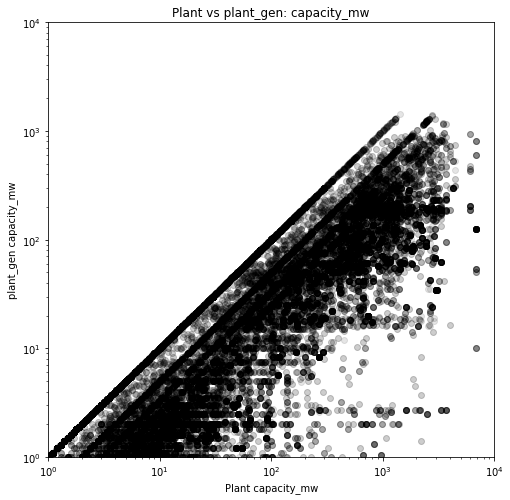

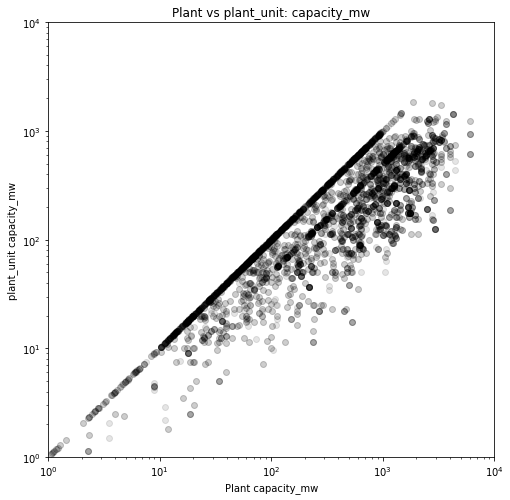

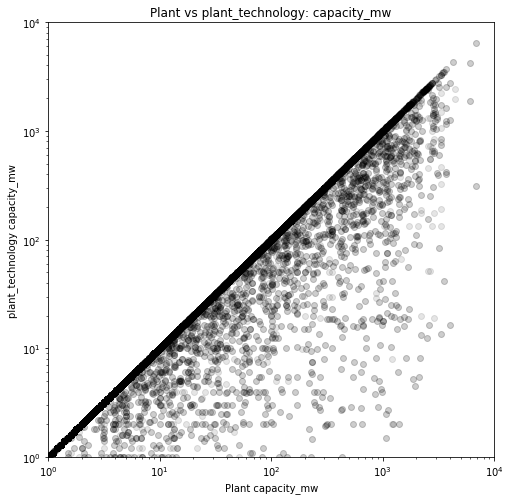

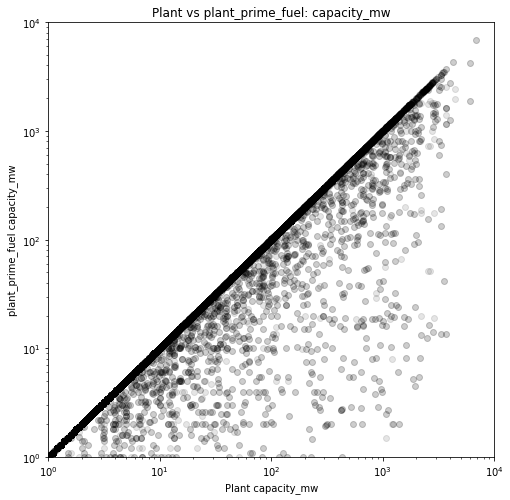

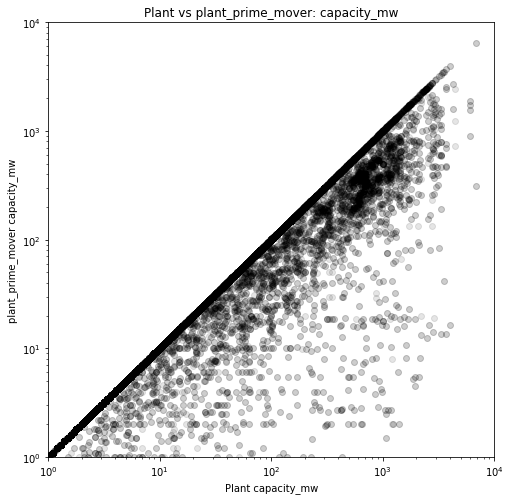

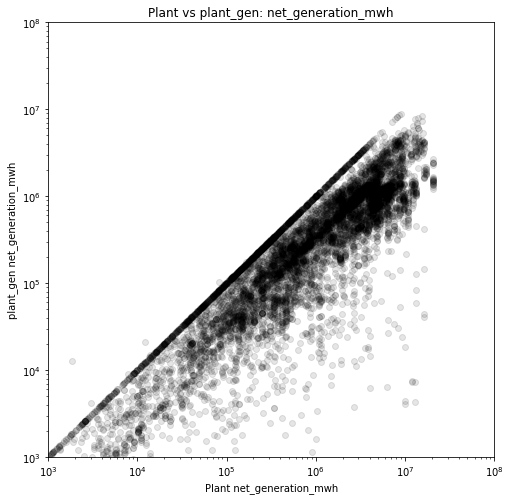

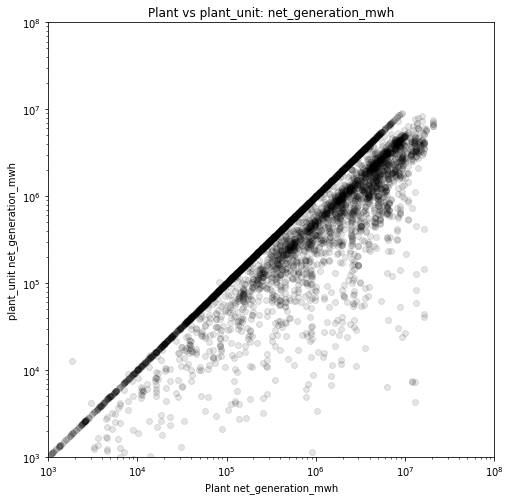

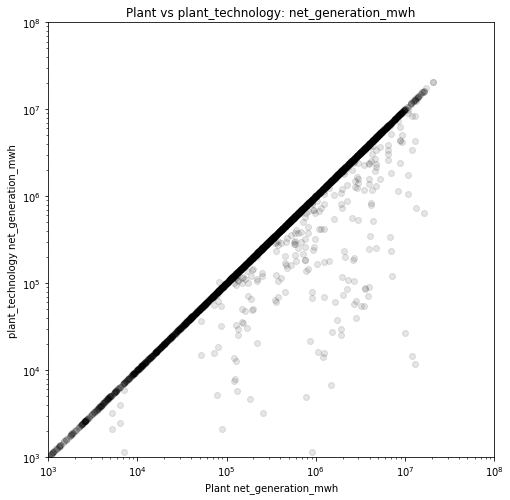

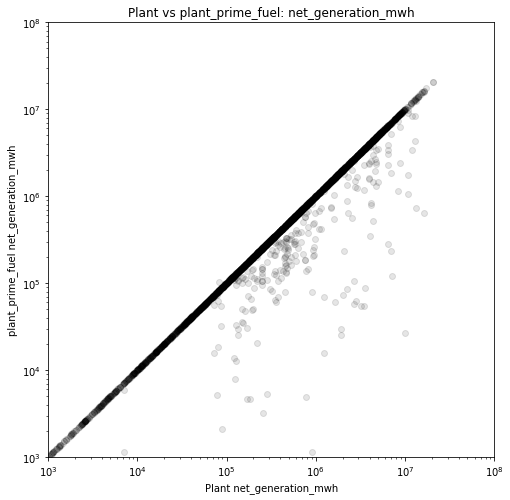

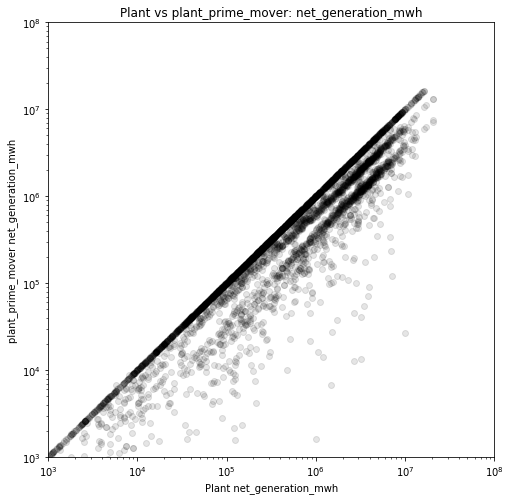

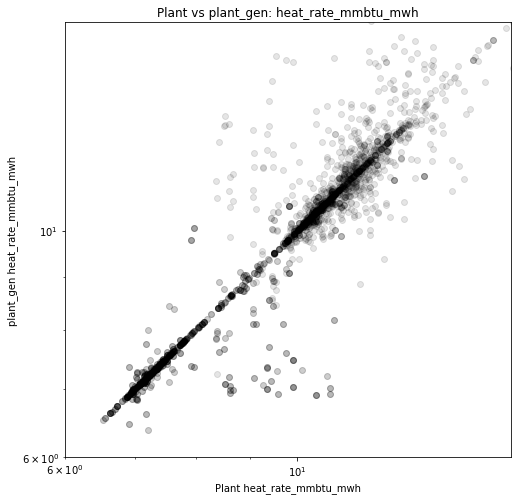

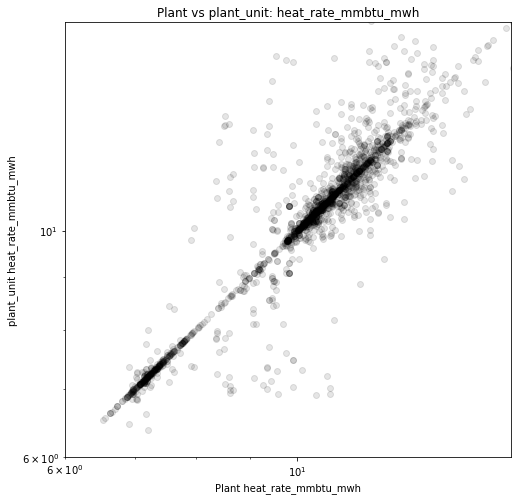

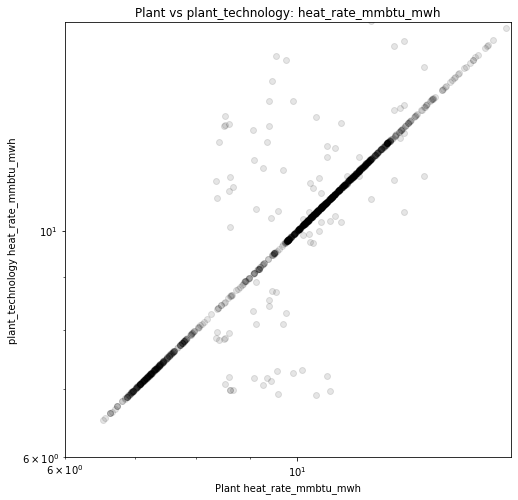

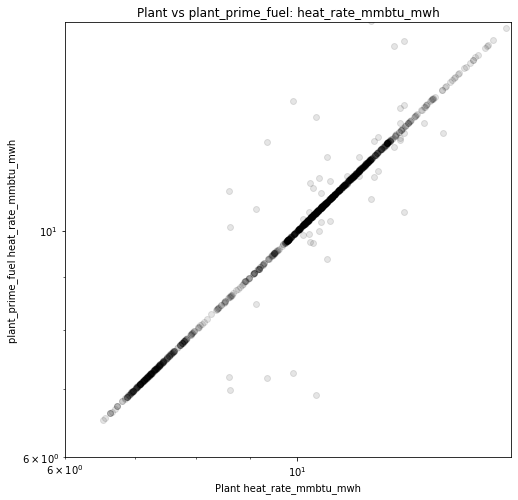

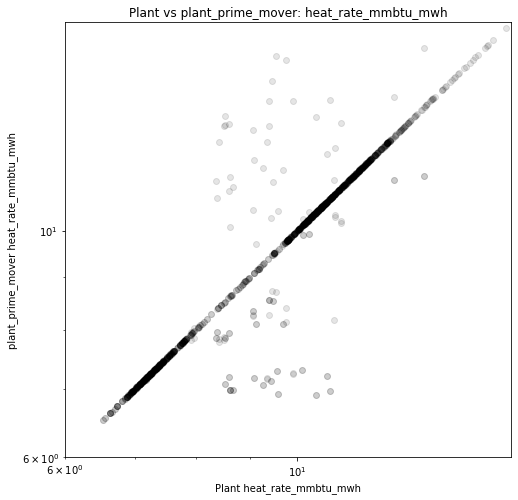

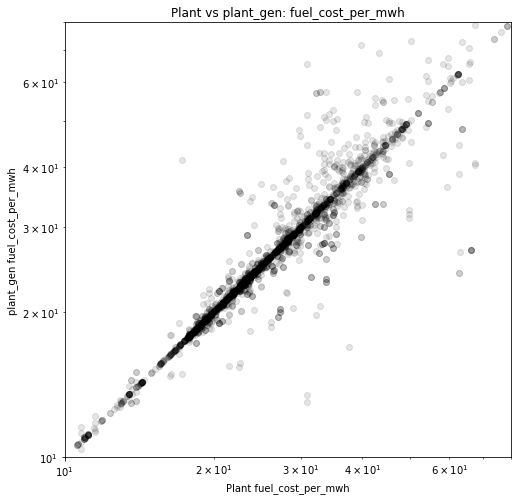

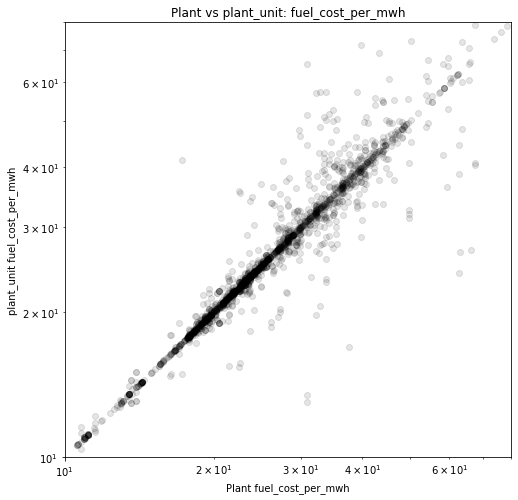

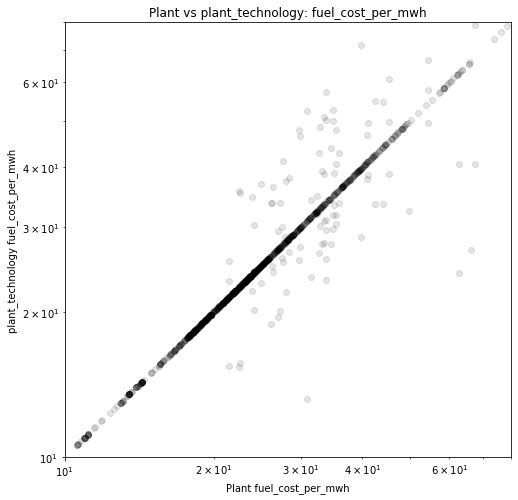

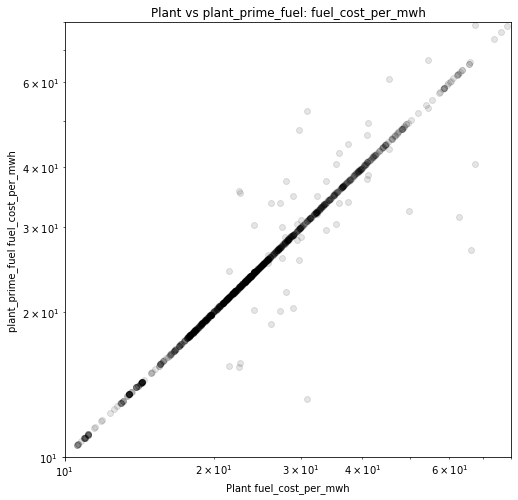

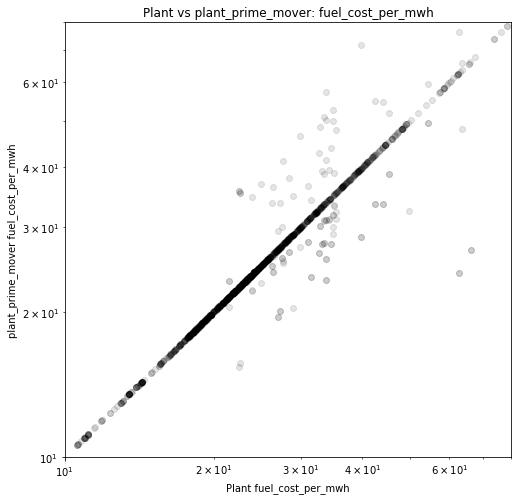

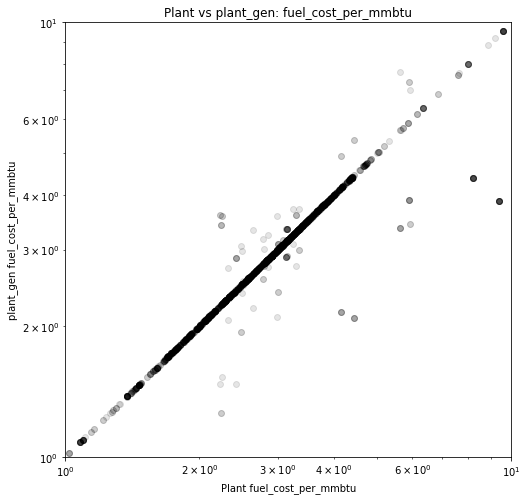

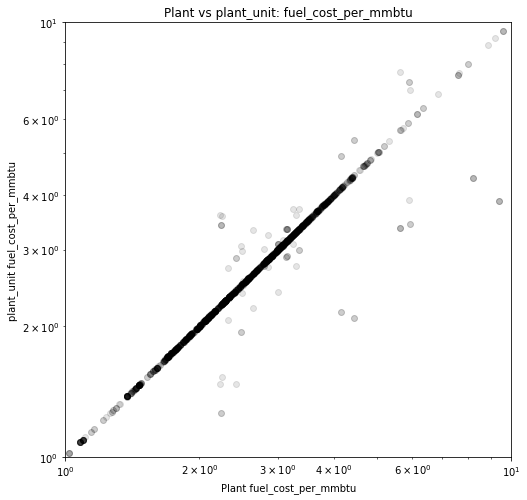

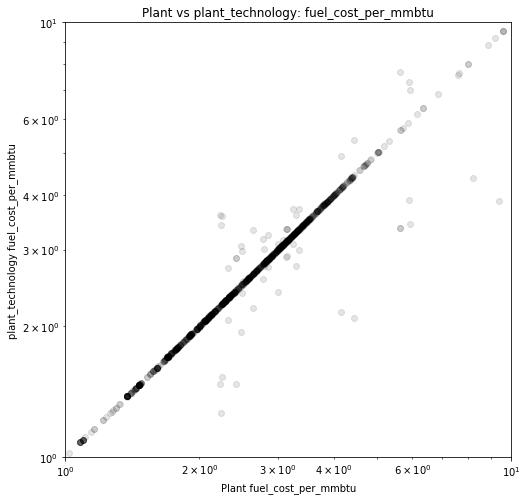

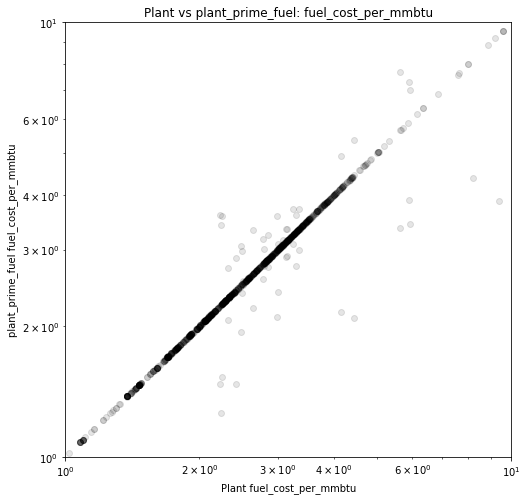

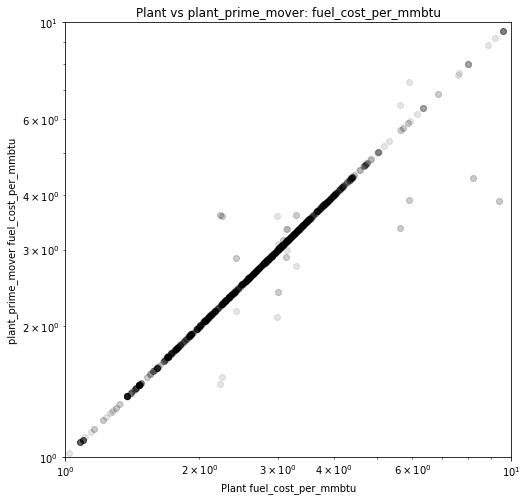

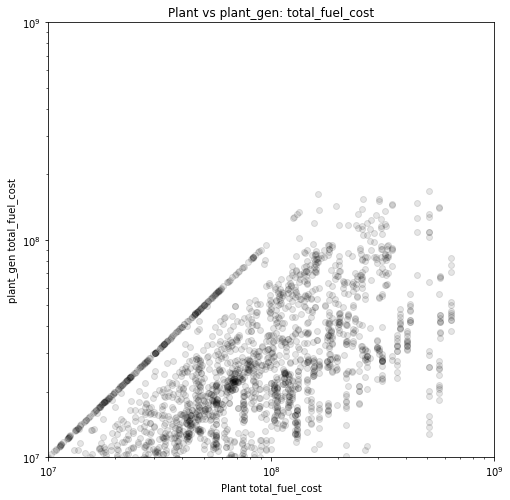

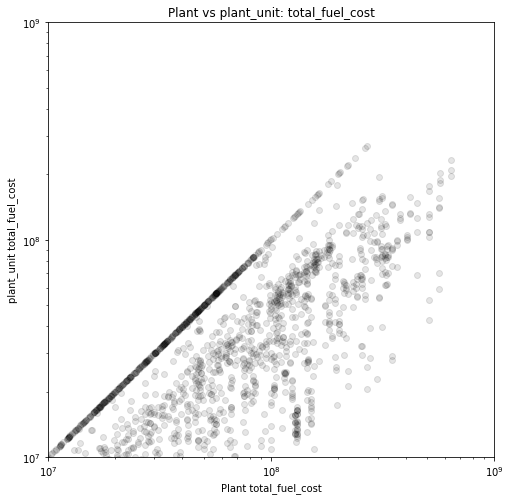

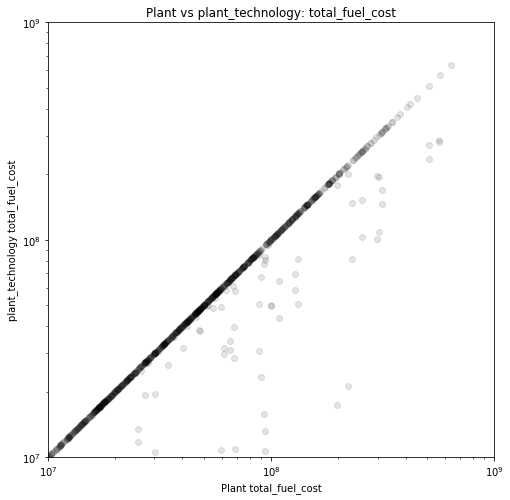

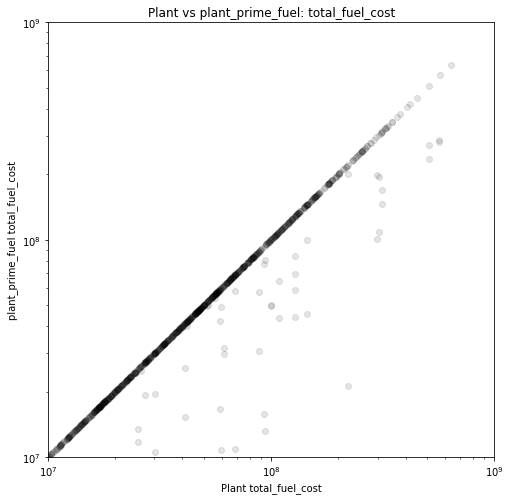

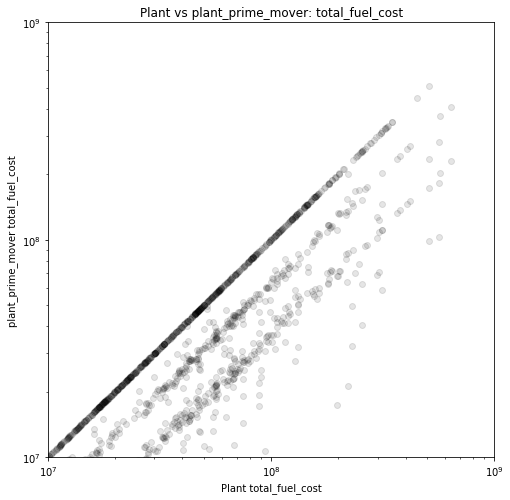

In [11]:
fields_to_plot = [
    # Simple Quantities
    'capacity_mw',
    #'opex_fuel',
    #'total_mmbtu',
    'net_generation_mwh',
    # Derived values
    #'capacity_factor',
    'heat_rate_mmbtu_mwh',
    'fuel_cost_per_mwh',
    'fuel_cost_per_mmbtu',
    'total_fuel_cost'
]

xy_limits = {
    # Simple Quantities
    'capacity_mw': (1e0, 1e4),
    'net_generation_mwh': (1e3,1e8),
    # Derived values
    'capacity_factor': (0,1.0),
    'heat_rate_mmbtu_mwh': (6,16),
    'fuel_cost_per_mwh': (10,80),
    'fuel_cost_per_mmbtu': (1e0,1e1),
    'total_fuel_cost': (1e7,1e9)
}

for field in fields_to_plot:
    plot_plant_vs_agg(compiled_plant_parts,field, xy_limits, scale="log")
#plot_eia_v_ferc1(pudl_dude, fields_to_plot, xy_limits)

In [12]:
def plot_gens_vs(compiled_plant_parts,part_name, data_col, weight_col, x_range):
    gen_df = compiled_plant_parts['plant_gen'][compiled_plant_parts['plant_gen'][data_col] != 0]
    part_df = compiled_plant_parts[part_name][compiled_plant_parts[part_name][data_col] != 0]
    if weight_col:
        weights_gen = gen_df[weight_col]
        weights_part = part_df[weight_col]
    else:
        weights_gen = None
        weights_part = None

    plt.hist(gen_df[data_col], 
             weights=weights_gen,
             range=x_range,
             bins=100,
             color="purple", #alpha=test_alpha,
             label="Generators")

    plt.hist(part_df[data_col], 
             weights=weights_part,
             range=x_range,
             bins=100,
             color="black",
             label=f'{part_name}')

    plt.title(f'Gens vs. {part_name}: {data_col}')
    plt.xlabel(data_col)
    plt.ylabel(None)
    plt.legend()
    plt.show()

In [13]:
x_ranges = {
    'capacity_mw' : (0,400),
    'net_generation_mwh': (0, 2500000),
    'fuel_cost_per_mmbtu': (0, 5),
    'fuel_cost_per_mwh': (0, 100),
    'total_fuel_cost': (0,10000000)
}

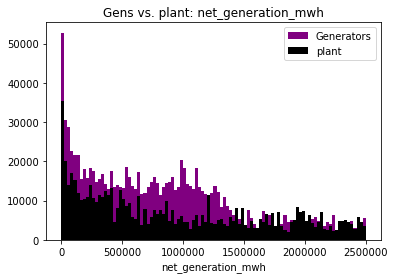

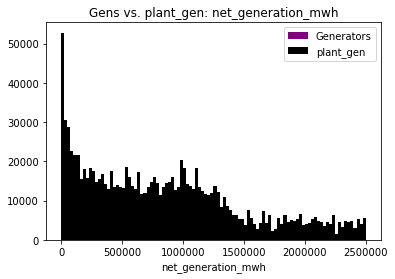

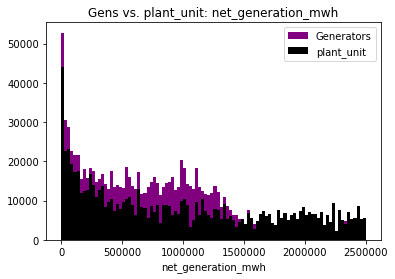

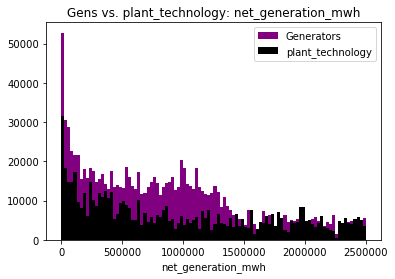

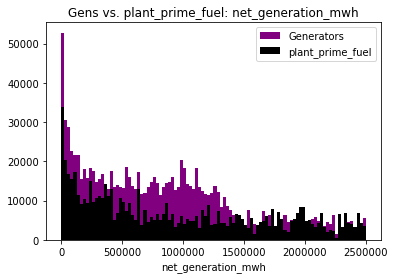

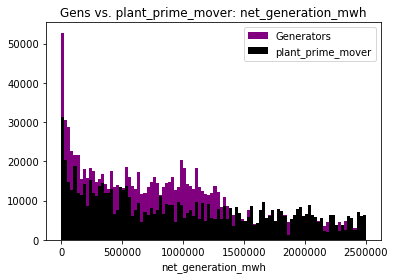

In [14]:
for part_name in compiled_plant_parts.keys():
    data_col =  'net_generation_mwh'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

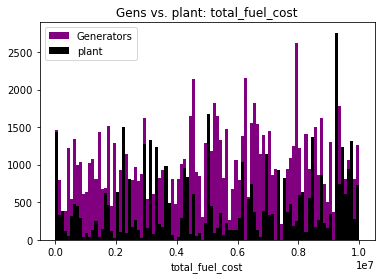

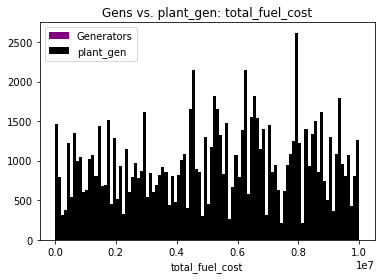

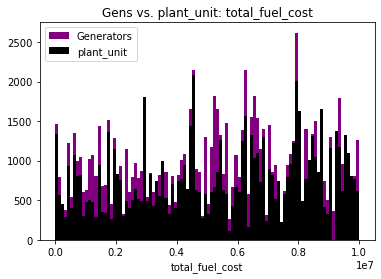

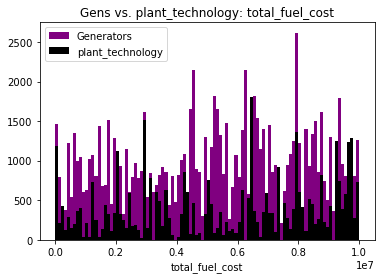

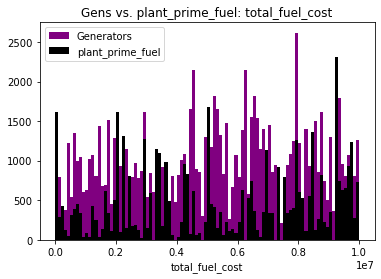

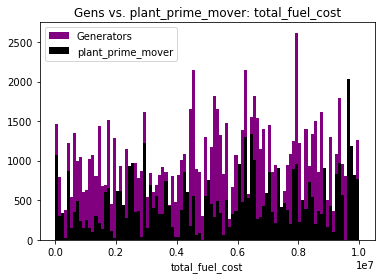

In [15]:
for part_name in compiled_plant_parts.keys():
    data_col =  'total_fuel_cost'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


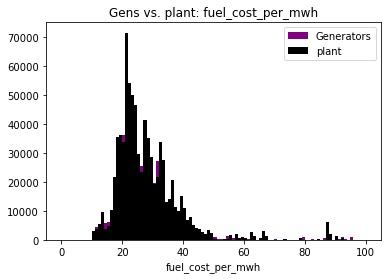

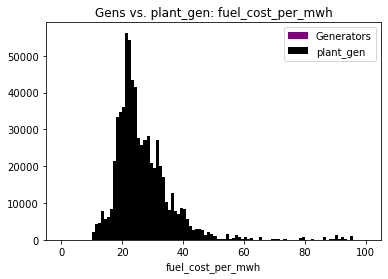

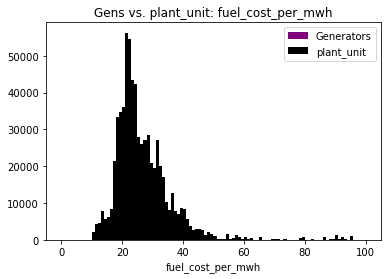

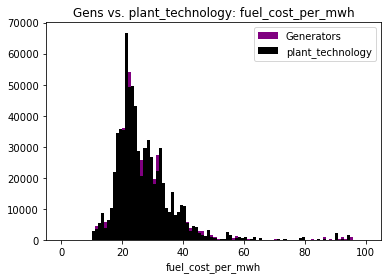

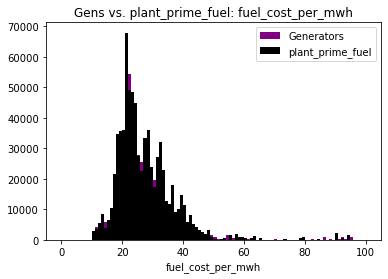

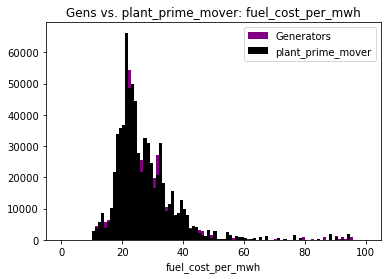

In [16]:
for part_name in compiled_plant_parts.keys():
    data_col =  'fuel_cost_per_mwh'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

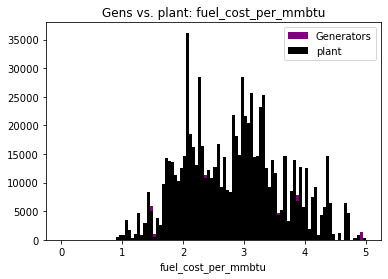

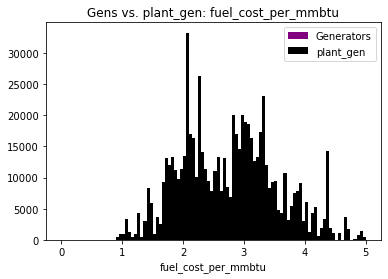

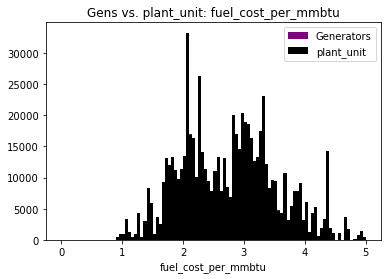

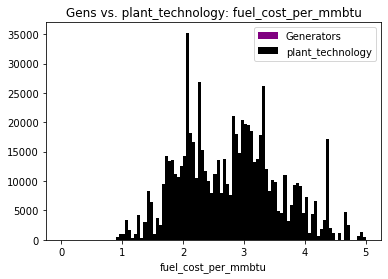

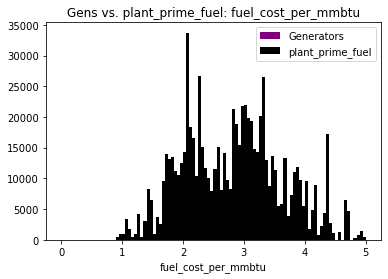

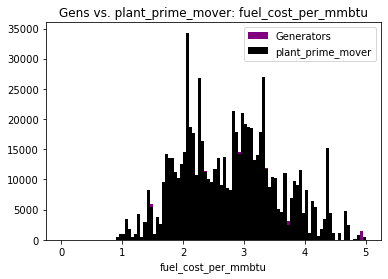

In [17]:
for part_name in compiled_plant_parts.keys():
    data_col =  'fuel_cost_per_mmbtu'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

## Playing with the compiled outputs 

In [18]:
# various tables to poke at for debuging
generat923 = self.grab_the_table('generation_eia923')
gens860 = self.grab_the_table('generators_eia860')
bga860 = self.grab_the_table('boiler_generator_assn_eia860')
own860 = self.grab_the_table('ownership_eia860')
plant = compiled_plant_parts['plant']
plant_gen = compiled_plant_parts['plant_gen']
plant_unit = compiled_plant_parts['plant_unit']
plant_fuel = compiled_plant_parts['plant_prime_fuel']
plant_tech = compiled_plant_parts['plant_technology']
plant_pm = compiled_plant_parts['plant_prime_mover']

In [19]:
plant_gen_agged = plant_gen.groupby(by=['utility_id_eia','plant_id_eia','fraction_owned','report_date']).sum().reset_index()

In [20]:
merge = plant.merge(plant_gen_agged,
                    on=['utility_id_eia','plant_id_eia','fraction_owned','report_date'],
                    suffixes=('_plant','_gen')).drop(columns=['fuel_cost_per_mmbtu_plant','fuel_cost_per_mmbtu_gen',
                                                              'heat_rate_mmbtu_mwh_plant', 'heat_rate_mmbtu_mwh_gen',
                                                              'fuel_cost_per_mwh_plant','fuel_cost_per_mwh_gen',
                                                             ])

In [27]:
#merge[merge['capacity_mw_gen'] != merge['capacity_mw_plant']].sample(60)

In [24]:
count_df = pd.DataFrame(index=list(compiled_plant_parts['plant'].columns))
for k,cpp_df in compiled_plant_parts.items():
    count_df = count_df.merge(
        pd.DataFrame(cpp_df[cpp_df['report_date'].dt.year ==2017].count(), columns=[k]),
        right_index=True, left_index=True)
count_df = count_df.merge(pd.DataFrame(count_df.sum(axis=1),columns=['total']),
                          right_index=True, left_index=True)

In [25]:
count_df

,plant,plant_gen,plant_unit,plant_technology,plant_prime_fuel,plant_prime_mover,total
fraction_owned,10913,28213,2561,12071,11803,12524,78085
utility_id_eia,10913,28213,2561,12071,11803,12524,78085
plant_id_eia,10913,28213,2561,12071,11803,12524,78085
report_date,10913,28213,2561,12071,11803,12524,78085
fuel_cost_per_mmbtu,594,1493,1039,623,609,781,5139
heat_rate_mmbtu_mwh,594,1493,1039,623,609,781,5139
fuel_cost_per_mwh,594,1493,1039,623,609,781,5139
total_fuel_cost,10913,28213,2561,12071,11803,12524,78085
net_generation_mwh,10913,28213,2561,12071,11803,12524,78085
capacity_mw,10913,28213,2561,12071,11803,12524,78085


In [ ]:
# if you want to look at an individaul plant
plant_unit[plant_unit['plant_id_eia'] ==6179]

In [ ]:
# selecting on two criteria (plant_id_eia and report_date)
plant_unit[(plant_unit['plant_id_eia'] == 260)]

In [ ]:
# you can see where fields are empty
plant_unit[plant_unit['capacity_mw'].isnull()]

In [ ]:
# you can see where fields are not empty
plant_unit[plant_unit['capacity_mw'].notnull()]

In [ ]:
own860.count()

In [ ]:
plant_gen_df.count()